### With first year data

In [2]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, roc_auc_score, confusion_matrix, classification_report

In [3]:
df = pd.read_csv('data/raw_dataset.csv')
df.shape

(4424, 35)

In [4]:
print("Original shape:", df.shape)
print(df["Target"].value_counts())

Original shape: (4424, 35)
Target
Graduate    2209
Dropout     1421
Enrolled     794
Name: count, dtype: int64


In [5]:
df = df[df["Target"].isin(["Dropout", "Graduate"])].copy()
print("\nAfter filtering to Dropout/Graduate only:", df.shape)
print(df["Target"].value_counts())


After filtering to Dropout/Graduate only: (3630, 35)
Target
Graduate    2209
Dropout     1421
Name: count, dtype: int64


In [6]:
numeric_cols = [
    "Curricular units 1st sem (grade)",
    "Curricular units 2nd sem (grade)",
    "Unemployment rate",
    "Inflation rate",
    "GDP",
]


In [7]:
all_feature_cols = [c for c in df.columns if c != "Target"]
categorical_cols = [c for c in all_feature_cols if c not in numeric_cols]


In [8]:
df[numeric_cols] = df[numeric_cols].apply(pd.to_numeric, errors="coerce")
df = df.dropna(subset=numeric_cols)

In [9]:
df["y"] = (df["Target"] == "Dropout").astype(int)

X = df[all_feature_cols]
y = df["y"]

In [10]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    random_state=42,
    stratify=y
)

### Preprocessing:


In [11]:
preprocess = ColumnTransformer(
    transformers=[
        ("num", StandardScaler(), numeric_cols),
        ("cat", OneHotEncoder(handle_unknown="ignore"), categorical_cols),
    ]
)

### Define three models

In [12]:
log_reg = LogisticRegression(max_iter=2000)

rf = RandomForestClassifier(
    n_estimators=300,
    max_depth=None,
    min_samples_split=4,
    random_state=42,
    n_jobs=-1
)

xgb = XGBClassifier(
    n_estimators=400,
    learning_rate=0.05,
    max_depth=5,
    subsample=0.8,
    colsample_bytree=0.8,
    eval_metric="logloss",
    random_state=42,
    n_jobs=-1
)

In [13]:
pipe_log = Pipeline([("prep", preprocess), ("model", log_reg)])
pipe_rf  = Pipeline([("prep", preprocess), ("model", rf)])
pipe_xgb = Pipeline([("prep", preprocess), ("model", xgb)])

### Train models

In [14]:
pipe_log.fit(X_train, y_train)
pipe_rf.fit(X_train, y_train)
pipe_xgb.fit(X_train, y_train)

,steps,"[('prep', ...), ('model', ...)]"
,transform_input,None
,memory,None
,verbose,False
,transformers,"[('num', ...), ('cat', ...)]"
,remainder,'drop'
,sparse_threshold,0.3
,n_jobs,None
,transformer_weights,None
,verbose,False
,verbose_feature_names_out,True


### Evaluation function

In [15]:
def evaluate(model, name):
    print("\n" + "="*60)
    print(f"{name} results")
    print("="*60)
    y_pred = model.predict(X_test)
    y_proba = model.predict_proba(X_test)[:, 1]

    acc = accuracy_score(y_test, y_pred)
    auc = roc_auc_score(y_test, y_proba)
    cm = confusion_matrix(y_test, y_pred)

    print("Accuracy:", round(acc, 3))
    print("AUC:", round(auc, 3))
    print("Confusion Matrix:\n", cm)
    print("\nClassification report:\n", classification_report(y_test, y_pred))

evaluate(pipe_log, "Logistic Regression")
evaluate(pipe_rf,  "Random Forest")
evaluate(pipe_xgb, "XGBoost")


Logistic Regression results
Accuracy: 0.919
AUC: 0.968
Confusion Matrix:
 [[414  28]
 [ 31 253]]

Classification report:
               precision    recall  f1-score   support

           0       0.93      0.94      0.93       442
           1       0.90      0.89      0.90       284

    accuracy                           0.92       726
   macro avg       0.92      0.91      0.91       726
weighted avg       0.92      0.92      0.92       726


Random Forest results
Accuracy: 0.927
AUC: 0.972
Confusion Matrix:
 [[421  21]
 [ 32 252]]

Classification report:
               precision    recall  f1-score   support

           0       0.93      0.95      0.94       442
           1       0.92      0.89      0.90       284

    accuracy                           0.93       726
   macro avg       0.93      0.92      0.92       726
weighted avg       0.93      0.93      0.93       726


XGBoost results
Accuracy: 0.927
AUC: 0.971
Confusion Matrix:
 [[417  25]
 [ 28 256]]

Classification repo

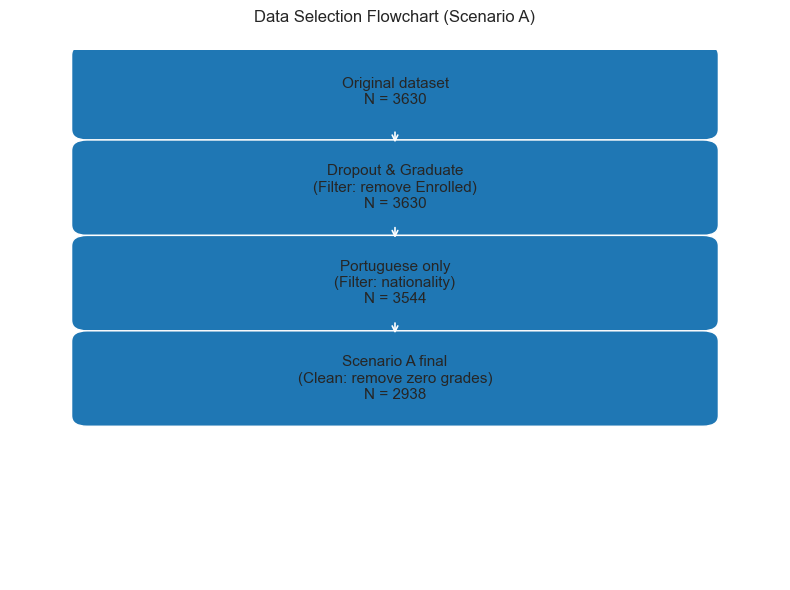

In [17]:
import matplotlib.pyplot as plt
from matplotlib.patches import FancyBboxPatch

# ---------- 1) הגדרות: עדכן לפי הדאטה שלך ----------
target_col = "Target"          # Dropout / Graduate / Enrolled
nationality_col = "Nacionality" # קוד לאזרחות
portuguese_code = 1            # בדאטה המקורי לרוב Portuguese=1 (אם אצלך שונה - עדכן!)

# עמודות ציונים לסינון "zero grades" (Scenario A בלבד)
grade_cols = ["Curricular units 1st sem (grade)", "Curricular units 2nd sem (grade)"]

# ---------- 2) פונקציות סינון ----------
def filter_remove_enrolled(df):
    return df[df[target_col].isin(["Dropout", "Graduate"])].copy()

def filter_portuguese_only(df):
    return df[df[nationality_col] == portuguese_code].copy()

def filter_remove_zero_grades_scenario_A(df):
    """
    מסיר שורות שבהן *כל* עמודות הציונים שהגדרת הן 0 (או חסרות).
    אם אצלך ההגדרה אחרת (למשל רק 1st sem), תגיד ואשנה.
    """
    g = df[grade_cols].fillna(0)
    mask = (g.sum(axis=1) > 0)   # נשאר אם יש לפחות ציון אחד חיובי
    return df[mask].copy()

# ---------- 3) בניית שלבים + ספירת N ----------
def build_steps(df):
    steps = []
    steps.append(("Original dataset", len(df)))

    df1 = filter_remove_enrolled(df)
    steps.append(("Dropout & Graduate\n(Filter: remove Enrolled)", len(df1)))

    df2 = filter_portuguese_only(df1)
    steps.append(("Portuguese only\n(Filter: nationality)", len(df2)))

    df3 = filter_remove_zero_grades_scenario_A(df2)
    steps.append(("Scenario A final\n(Clean: remove zero grades)", len(df3)))

    return steps

# ---------- 4) ציור Flowchart ----------
def draw_flowchart(steps, title="Data Selection Flowchart", save_path=None):
    fig, ax = plt.subplots(figsize=(8, 6))
    ax.axis("off")
    ax.set_title(title, pad=20)

    # מיקומים
    x = 0.1
    box_w = 0.8
    box_h = 0.14
    y_start = 0.85
    y_gap = 0.18

    for i, (label, n) in enumerate(steps):
        y = y_start - i * y_gap

        # קופסה
        box = FancyBboxPatch(
            (x, y), box_w, box_h,
            boxstyle="round,pad=0.02,rounding_size=0.02",
            linewidth=1
        )
        ax.add_patch(box)

        # טקסט
        ax.text(
            x + box_w/2, y + box_h/2,
            f"{label}\nN = {n}",
            ha="center", va="center", fontsize=11
        )

        # חץ למטה (חוץ מהאחרון)
        if i < len(steps) - 1:
            ax.annotate(
                "", xy=(x + box_w/2, y - 0.03),
                xytext=(x + box_w/2, y),
                arrowprops=dict(arrowstyle="->", linewidth=1.2)
            )

    plt.tight_layout()
    if save_path:
        plt.savefig(save_path, dpi=300, bbox_inches="tight")
    plt.show()

# ---------- 5) שימוש ----------
steps_A = build_steps(df)  # df שלך
draw_flowchart(steps_A, title="Data Selection Flowchart (Scenario A)", save_path="flowchart_scenarioA.png")

In [ ]:
Nacionality